# Exploratory Data Analysis

Target:
- Look for potential edges between users
- EDA

What potential edges between users can we extract from the data we have from Twitter. What connections do we have between the users.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed
from ipywidgets import IntSlider
import networkx as nx
import re

In [2]:
import sys
sys.path.append('..')
from transform.read_transform import read_transform

## Import Data

In [3]:
data = read_transform(path_tweets='../data/TW.csv', path_retweets='../data/RT.csv', 
                      join_method='concat', 
                      hashtags_as_list=False, mentions_as_list=False)
print(data.shape)

(44334, 19)


In [22]:
data.sample(2)

,creation_date,description,entities_hashtags,favourite_count,followers_count,friends_count,full_text,location,mentions,profile_created_at,protected,retweet_count,search_key,tweet_id,user_id,user_name,user_screen_name,is_retweet,RT_of_ID
36925,2021-04-07 05:39:31+00:00,NaN,Health,0,18,12,RT @HumanityWarior7: Healthy Lifestyle keep Ph...,NaN,'HumanityWarior7',2021-02-03 15:36:51+00:00,False,607,#vegetarian,1379670150283075585,1356989839212568579,Drishti,Drishti_insan,True,NaN
7780,2021-04-05 21:40:52+00:00,Twitter feed for Catford SE6 & local area - Fr...,"thejohnfleming, blog, 100daysofcode, digitalma...",0,5736,1458,RT @sanshui596: “Bloody Norah!” – Who was she?...,"Catford, Lewisham, London, SE6",'sanshui596',2011-03-11 22:34:26+00:00,False,29,#London,1379187305307590661,264439198,Catford SE6,catford_se6,True,NaN


## Analysis

### Retweet COunt als mögliches Knotenattribut?

In [18]:
data[['user_screen_name', 'retweet_count']].groupby('user_screen_name').median()

,retweet_count
user_screen_name,
004clinden,3.0
007201_,1.0
0123Mara,84.0
01Nalka,74.0
01kido03,4.0
...,...
zudabar,0.0
zuiko21,11.0
zulily,12.5


### User Activity

In [21]:
data.drop_duplicates(subset=['tweet_id', 'user_screen_name'])['user_screen_name'].value_counts()

researchmrx       929
CounterIreland    326
WhatsOnOLIO       252
5stocksinto       122
vanprobindia      117
                 ... 
FeastNorfolk        1
amy_quirk           1
time2riot           1
nileshpathak24      1
earthtorosita       1
Name: user_screen_name, Length: 18626, dtype: int64

### SInd Locations eindeutig?

In [9]:
data.drop_duplicates(subset=['location', 'user_screen_name']).groupby('location').count()['user_id'].sort_values(ascending=False)

location
London, England              297
United States                207
London                       197
United Kingdom               186
England, United Kingdom      145
                            ... 
Reading in England             1
Reading, Henley on thames      1
Reading,Pa                     1
Ready - Get Sett -  Gone       1
Middle of Nowhere              1
Name: user_id, Length: 7071, dtype: int64

Nein sind sie nicht und somit kein gutes Attribut für unsere Analyse.

## Retweets vs Tweets

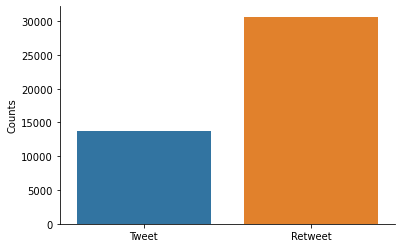

In [30]:
tmp = data.groupby('is_retweet').count()['tweet_id']

p = sns.barplot(x=tmp.index, y=tmp, )
plt.xticks(ticks=[0, 1], labels=['Tweet', 'Retweet'])
p.set_xlabel('')
p.set_ylabel('Counts')
sns.despine()

plt.show()

**Interpretation:**

We have almost the same amount of Tweets and Retweets. THis is probably due to the data collection per search key, where also Retweets can be collected as Tweets Data.

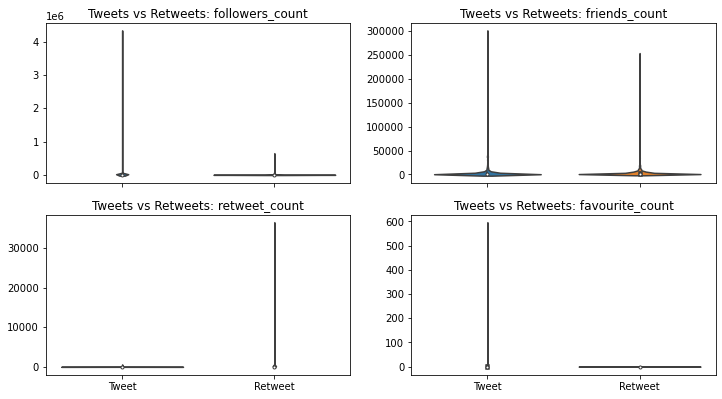

In [31]:
tmp = data[['is_retweet', 'followers_count', 'friends_count', 'retweet_count', 'favourite_count']]

plt.subplots(figsize=(12,10))
for i, col in enumerate(tmp.columns.to_list()[1:]):
    plt.subplot(3,2,i+1)
    plt.title(f'Tweets vs Retweets: {col}')
    p = sns.violinplot(x=tmp['is_retweet'], y=tmp[col])
    p.set_ylabel('')
    
    if i > 1:
        plt.xticks(ticks=[0, 1], labels=['Tweet', 'Retweet'])
    else:
        plt.xticks(ticks=[0, 1], labels=['', ''])
    p.set_xlabel('')
    
plt.show()

**Interpretation:**

ONe can see that we have a very high variance in our dataset because of some accounts which have a lot more follower and  so on. So in the next step I will only take all values lower than 90 Percentile to exclude the outtliers in the data.

In [32]:
tmp = data[['is_retweet', 'followers_count', 'friends_count', 'retweet_count', 'favourite_count']]
lower_than_quantile = .98

def plot_TW_RT_violines(lower_than_quantile):
    plt.subplots(figsize=(12,10))
    for i, col in enumerate(tmp.columns.to_list()[1:]):
        plotdata = tmp[tmp[col] <= tmp[col].quantile(lower_than_quantile)] 

        plt.subplot(3,2,i+1)
        plt.title(f'{col} / FilterQuantile: {lower_than_quantile}')
        p = sns.violinplot(x=plotdata['is_retweet'], y=plotdata[col])
        p.set_ylabel('')

        if i > 1:
            plt.xticks(ticks=[0, 1], labels=['Tweet', 'Retweet'])
        else:
            plt.xticks(ticks=[0, 1], labels=['', ''])
        p.set_xlabel('')

    plt.show()
    
interactive(plot_TW_RT_violines, lower_than_quantile=(.1, 1., .02))

interactive(children=(FloatSlider(value=0.54, description='lower_than_quantile', max=1.0, min=0.1, step=0.02),…

**Interpretation:**

We can see that we have very long-tailed distributions along both the Tweets and Retweets.

Followers count are very similar to each other. If the higher quantiles were included the Favourite counts of people which create initial Tweets are higher range, but if excluded both are equally balanced.

This is the same for the friends count. It would approppriate to check if there are Correlations between Friends Count all the quantitative values.

Regarding to the Retweet it is very interesting to see that most tweets not get retweeted and only a few were. It shows that the most Retweets are actually Retweets itself. Is this possible?

### Counts per SearchKey

Frage: Wieviele Tweets wurde überhaupt gesammelt, über die einzelen Posts hinweg?

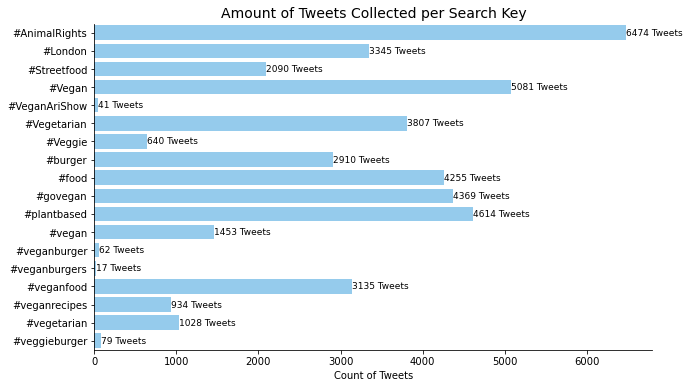

In [33]:
tmp = data.groupby('search_key').count()['tweet_id']

fig = plt.subplots(figsize=(10,6))

p = sns.barplot(x=tmp, y=tmp.index, color='lightskyblue')
p.set_title('Amount of Tweets Collected per Search Key', loc='center', fontdict={'size':14})
p.set_xlabel('Count of Tweets')
p.set_ylabel('')
sns.despine()

for i, label in enumerate(tmp.index.to_list()):
    plt.text(x=tmp.loc[label], y=i, s=str(tmp.loc[label]) + ' Tweets', ha='left', va='center', size=9)

**Interpretation:**

Wurden bei den Suchwörtern, die weniger als 250 (Limit) keine weiteren Posts mehr gefunden? Suchwörter mit den meisten Tweets und Retweets sind "Vegan", "veganfood", "dairyfree", "crueltyfree".

### Posts

In [34]:
tmp = pd.concat([data['creation_date'].dt.weekday, data['creation_date'].dt.hour], axis=1)
tmp.columns = ['weekday', 'hour']
tmp = tmp.sort_values(by='weekday', ascending=True, ignore_index=True)

replacement = {}
days = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
for i, day in enumerate(days):
    replacement[i] = day
    
tmp['weekday'] = tmp['weekday'].replace(replacement)

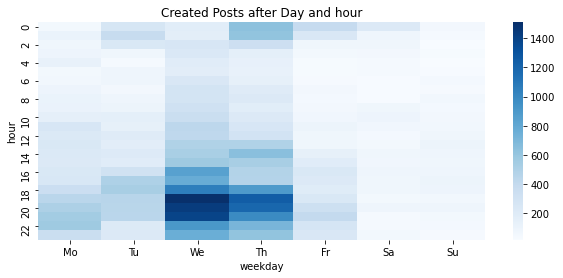

In [35]:
fig = plt.subplots(figsize=(10,4))
p = sns.heatmap(
    data=pd.crosstab(
        index=tmp['hour'], 
        columns=tmp['weekday']
                    )[days], 
    cmap='Blues', 
    cbar=True
)
p.set_title('Created Posts after Day and hour')
plt.show()

## Profile Created at

In [48]:
tmp = data.drop_duplicates()
tmp = pd.concat([tmp['profile_created_at'].dt.weekday, tmp['profile_created_at'].dt.hour], axis=1)
tmp.columns = ['weekday', 'hour']

tmp = tmp.sort_values(by='weekday', ascending=True, ignore_index=True)

replacement = {}
days = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
for i, day in enumerate(days):
    replacement[i] = day
    
tmp['weekday'] = tmp['weekday'].replace(replacement)

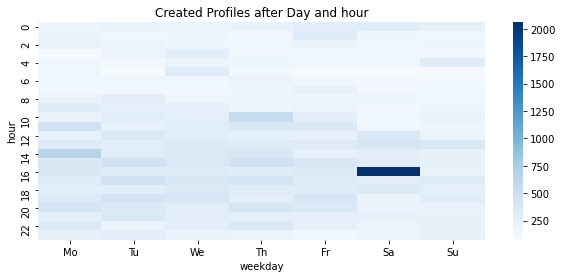

In [50]:
fig = plt.subplots(figsize=(10,4))
p = sns.heatmap(
    data=pd.crosstab(
        index=tmp['hour'], 
        columns=tmp['weekday']
                    )[days], 
    cmap='Blues', 
    cbar=True
)
p.set_title('Created Profiles after Day and hour')
plt.show()

**Interpretation:**

Der Plot zeigt, wann die Posts gepostet wurden nach Wochentagen und der Tageszeit. Diese Grafik ist mit Vorsicht zu geniessen, da auch nur über einen bestimmten Tag Daten gesammelt wurde. Dadurch ist anzunehmenm dass darum, die meisten Post von Montag und Dienstag stattfanden.

Die Grafik zeigt, dass die häufigsten Tweets in den Hashtags von Montag Abend un Dienstabend stammen.

In [36]:
search_keys = data['search_key'].unique()

def plot_heatmap(search_key):
    tmp = data[data['search_key'] == search_key]
    tmp = pd.concat([tmp['creation_date'].dt.weekday, tmp['creation_date'].dt.hour], axis=1)
    tmp.columns = ['weekday', 'hour']
    tmp = tmp.sort_values(by='weekday', ascending=True, ignore_index=True)

    replacement = {}
    days = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
    for i, day in enumerate(days):
        replacement[i] = day
    tmp['weekday'] = tmp['weekday'].replace(replacement)
    
    fig = plt.subplots(figsize=(10,4))
    p = sns.heatmap(
            pd.crosstab(
            index=tmp['hour'], 
            columns=tmp['weekday']
                        ), 
        cmap='Blues', 
        cbar=True
    )
    p.set_title('Created Posts after Day and hour for Search Key <{}>'.format(search_key))
    plt.show()
    
interactive(_interactive__interact_f=plot_heatmap, search_key=search_keys)

interactive(children=(Dropdown(description='search_key', options=('#food', '#govegan', '#London', '#plantbased…

**Interpretation:**

Populäre Hashtags sind oftmals sehr viele von der gleichen Uhrzeit vorhanden. ZB Fitness, Food, etc. Dies liegt an der beschränkten Anzahl der Daten, die gesammelt wurden (250 Tweets pro Hashtag). Weniger beliebte Hashtags ziehen sich über mehrere Tage hinweg.

### Correlations

Do we have any correlations between our quantitative variables?

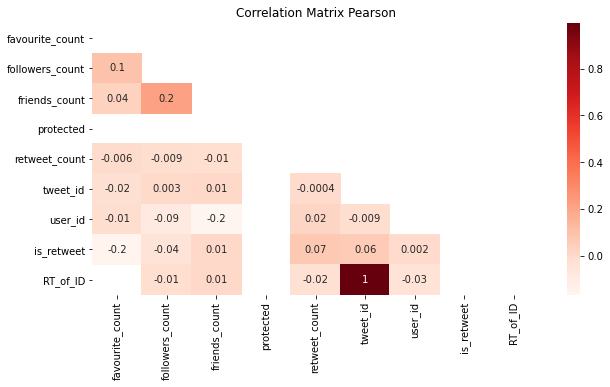

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
p1=sns.heatmap(data.corr(), 
              cmap='Reds', annot=data.corr(method='pearson'), fmt='.1g', cbar=True, mask=np.triu(data.corr())             )
p1.set_title('Correlation Matrix Pearson')

plt.show()


### Mentions - Erwähnungen

In [38]:
tmp = data['mentions'].str.replace("'", "").str.split(', ')

count_mentions = []
for mention in tmp:
    if type(mention) == list:
        count_mentions.append(len(mention))
    if type(mention) == float:
        count_mentions.append(0)

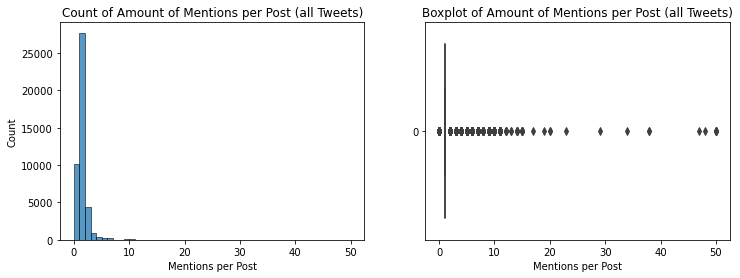

In [39]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

p1 = sns.histplot(data=count_mentions, bins=50, ax=ax[0])
p1.set_title('Count of Amount of Mentions per Post (all Tweets)')
p1.set_xlabel('Mentions per Post')

p2 = sns.boxplot(data=count_mentions, ax=ax[1], orient='h')
p2.set_title('Boxplot of Amount of Mentions per Post (all Tweets)')
p2.set_ylabel('')
p2.set_xlabel('Mentions per Post')
plt.show()

**Interpretation:**

Der Plot zeigt, dass wir viele Mentions in unseren Daten haben, vor allem in der Range 0-5. Long-Tail shape und Rechtsschiefe Verteilung der Daten. 

In den Retweets werden meistens auch die vorherigen Tweetveröffentlicher erwähnt. Deshalb haben wir hier eine hohe Anzahl an 1 Erwähnnungen im Histogram angezeigt.

## Network with Mentions only

H: It is possible to draw a graph network with the user mentions only.

Ich entferne im Vorhinein alle Nutzer, die über keine Verbindungen verfügen.

In [51]:
tmp = data[['mentions', 'user_screen_name']]
tmp = tmp[tmp['mentions'].isnull() == False]
tmp.loc[:,'mentions'] = tmp.loc[:,'mentions'].str.replace("'", "").str.split(', ')
print(tmp.shape)

tmp = tmp.set_index('user_screen_name')
tmp.head(2)

(34171, 2)


,mentions
user_screen_name,
ReAnimetron,[byOceanEyes]
Jenna_Blum,"[AMIGHTYBLAZE, fascicles]"


In [52]:
tmp = tmp.to_dict()['mentions']

In [53]:
print(list(tmp.keys())[3] , ": ", tmp[list(tmp.keys())[201]])

DGSpeaks :  ['LifeofRio']


In [54]:
G = nx.Graph()

In [55]:
new = {} # only nodes with connections
nbr_connections = 2

for key, val in tmp.items():
    if type(val) != float:
        if len(val) >= nbr_connections:
            new[key] = val
# Add nodes
for key, val in new.items():
    G.add_node(key)
    if type(val) != float:
        for v in val:
            G.add_node(v)

In [56]:
# Add edges
for key, val in new.items():
    if type(val) != float:
        for v in val:
            G.add_edge(key, v)

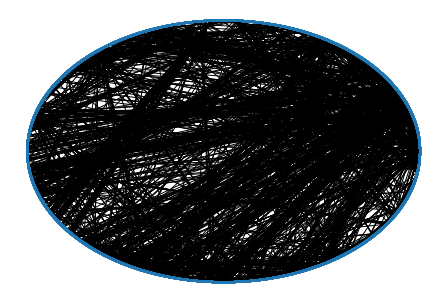

In [57]:
nx.draw_circular(G, node_size=3)

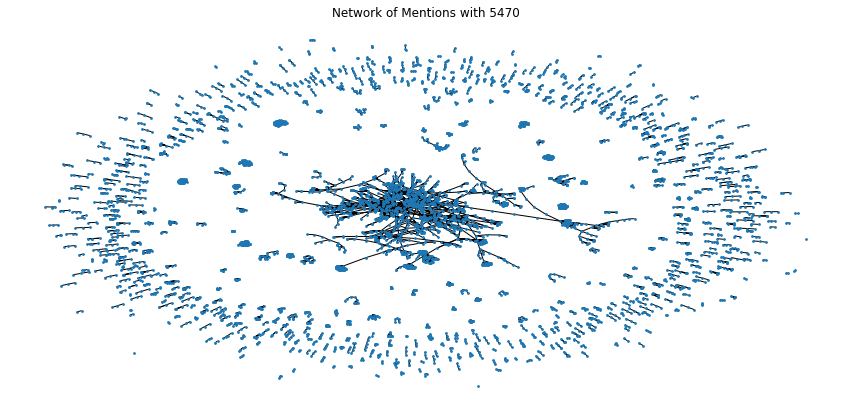

In [58]:
fig = plt.subplots(figsize=(15,7))
nx.draw(G, with_labels=False, node_size=3)
plt.title('Network of Mentions with {}'.format(len(G.nodes)))
plt.show()

**Interpretation**:

We have a lot of data with less connections as we can see on the other ring. We can also see that with a increased amount of data the innter networks start to grow with morre connections to the initial dots. 

The Tool networkx tends to be very slow when it comes to plotting more data. I think we should use the tool Gephi to analyse our Twitter data.

In [45]:
tmp = data['mentions'].str.extractall(r"'(\w+)'")
tmp = tmp.reset_index(drop=True).value_counts()

In [46]:
tmp = tmp.sort_values(ascending=False)

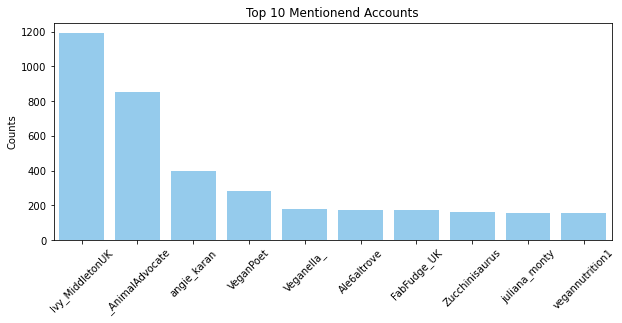

In [47]:
top = 10

plt.subplots(figsize=(10, 4))
p = sns.barplot(x=tmp.iloc[:top].index.to_numpy(), y=tmp.iloc[:top].to_list(), color='lightskyblue')
p.set_title(f'Top {top} Mentionend Accounts')
p.set_ylabel('Counts')
plt.xticks(ticks=[i for i in range(top)], 
           labels= [string[0] for string in tmp.iloc[:top].index.to_list()] , 
           rotation=45
          )
plt.show()

**Interpretation:**

One User has a lot of mentions in the dataset "loveinlife" and "FabFudge_UK". Perhaps this user is a Influencer within this hashtag group. The other ones are pretty evenly distributed.

## Hashtags

> Is it possible to create a Network with used hashtags too?

### Extraction of a list of used Hashtags in Posts

In [48]:
hashtags = data['entities_hashtags'].str.split(', ').to_numpy().tolist()
hashtags_ = []

for sublist in hashtags:
    if type(sublist) != float:
        for i in sublist:
            hashtags_.append(i)
hashtags = hashtags_.copy()

In [49]:
finds_per_search = data['search_key'].value_counts()
finds_per_search = finds_per_search.reset_index()
finds_per_search.columns = ['search_key', 'tweet_counts']
finds_per_search.head(2)

,search_key,tweet_counts
0,#AnimalRights,4971
1,#Vegan,3797


In [50]:
tmp = pd.DataFrame(data=hashtags).value_counts()
tmp = tmp.reset_index(name='count_hashtag')
tmp = tmp.rename(columns={0:'search_key'})
tmp.head(2)

,search_key,count_hashtag
0,vegan,3349
1,veganfood,1456


In [ ]:
hashtags_ = list(set(hashtags_)) #only once the same hashtag to write file
print('Amount of Distinct Hashtags: {}\n'.format(len(hashtags_)))
with open('../collect/hashtags.txt', 'w') as file:
    for tag in hashtags_:
        # Workaround to avoid chinese words which cant be written to txt
        if re.match(pattern=r"^[a-zA-Z0-9]", string=tag): 
            try:
                file.write('#'+tag+'\n')
            except Exception as e:
                print(e, '--> Skipping Word: {}'.format(tag))
                
print(50*'-')
print('Text-File with hashtags was written.')

## Structuring Data for Gephi Import

Gephi Data Structure:
https://gephi.org/users/supported-graph-formats/csv-format/

In [59]:
nx.write_gexf(G, path='./myData/hashtag_data.gexf')

## Load data from Google Drive

In [8]:
import requests
from bs4 import BeautifulSoup

In [48]:
r = requests.get('https://drive.google.com/drive/u/0/folders/1EuS-oOMSMH_0UE5bxKgAwExjFKxoM3tq')

soup = BeautifulSoup(r.text, 'html.parser')

In [49]:
# Extract doc titles
parsed = soup.find_all('div', attrs={'class':'Q5txwe'})

doc_titles = []
for i in parsed:
    doc_titles.append(i.text)
print(doc_titles)

['Mario.csv', 'Thomas.csv', 'TW.csv']


In [46]:
parsed = soup.find_all('div', attrs={'data-target':'doc'})

download_id = []
for content in parsed:
    download_id.append(content['data-id'])
    
print(download_id)

['1BRZYnpT0XErqPsHy9NmUfVye81Z-FTEK', '17eyDiLGjPl5TEFgHvpwu4ku6suw_OI-P']


In [47]:
for doc_id in download_id:
    path = 'https://drive.google.com/uc?export=download&id=' + doc_id
    df = pd.read_csv(path)
    print(df)

      Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0              0             0               0               0.0   
1              1             1               1               1.0   
2              2             2               2               2.0   
3              3             3               3               3.0   
4              4             4               4               4.0   
...          ...           ...             ...               ...   
6106        6106           251             251               NaN   
6107        6107           252             252               NaN   
6108        6108           253             253               NaN   
6109        6109             0               0               NaN   
6110        6110             1               1               NaN   

      Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                    0.0                   0.0                     0.0   
1                    1.0           